In [1]:
import ROOT as r
import coffea
import coffea.hist as hist
from coffea.nanoevents.methods import vector
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

from pyjet import cluster
import awkward as ak
import mplhep

from sklearn.cluster import DBSCAN
import numba

Welcome to JupyROOT 6.18/00


In [2]:
import awkward as ak
from coffea import hist, processor


# register our candidate behaviors
from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

def dR(x,y):
    dphi=(x[1]-y[1] +np.pi) %(2*np.pi)-np.pi
    deta=(x[0]-y[0])    
    return (dphi**2+deta**2)**0.5

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "cluster": hist.Hist(
                "Events",
                hist.Cat("algo", "algo"),
                hist.Bin("cls_matched",'dR_cls_matched',2,0,2),
                hist.Bin("llp_matched",'dR_llp_matched',2,0,2),                
                hist.Bin("eta", "eta", 40, -3, 3),                
                hist.Bin("phi", "phi", 40, -np.pi, np.pi),
                hist.Bin("size", "Cluster size", 25, 0, 1000),                
            ),
            "cluster_spread": hist.Hist(
                "Events",
                hist.Cat("algo", "algo"),
                hist.Bin("llp_matched",'dR_llp_matched',2,0,2),                                
                hist.Bin("eta_sd", "eta_sd", 20, 0, 1),                
                hist.Bin("phi_sd", "phi_sd", 20, 0, 1),                
                hist.Bin("width", "R(eta_sd,phi_sd)", 20, 0, 1),
            ),            
            "nCluster": hist.Hist(
                "Events",
                hist.Cat("algo", "algo"),
                hist.Bin("nClusters", "nCluster", 10, 0, 10),                
            ),
             "delta_cls": hist.Hist(
                "Events",
                hist.Bin("dR", "dR(CA_cls,db_cls)", 20, 0, 1),
            ),
             "deltaR_llp": hist.Hist(
                "Events",
                hist.Cat("algo", "algo"),
                hist.Bin("dR", "dR(cls,llp)", 20, 0, 1),                 
            ),
            'llp': hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("gLLP_e", "gLLP_e", 50, 0, 500),
                hist.Bin("gLLP_pt", "gLLP_pt", 50, 0, 500),                
            ),
            'llp_eff': hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("Pass", "LLP decay z", 50, 500, 1200),
                hist.Bin("Denom", "LLP decay z", 50, 500, 1200),                
            ),            
                        
        })

    @property
    def accumulator(self):
        return self._accumulator


    def CAcluster(self,X,dR=1.0,nCore=50):
        vectors=ak.zip({
            'pt':ak.ones_like(X.phi),
            'eta':X.eta,
            'phi':X.phi,
            'mass':ak.zeros_like(X.phi)
        })
        cls_eta=[]
        cls_phi=[]
        cls_size=[]
        ncls   =[]
        cls_eta_sd=[]
        cls_phi_sd=[]
        cls_width=[]    
        for v in vectors:
            v = ak.to_numpy(v)
            v = np.array([(i[0],i[1],i[2],i[3]) for i in v],
                         dtype=[(u'pT', '<f8'), (u'eta', '<f8'), (u'phi', '<f8'), (u'mass', '<f8')])
            clusterVals = cluster(v,R=dR,algo="cambridge")
            #include all rechits with ptmin=0
            _jets = clusterVals.inclusive_jets(ptmin=0)
            etas=[j.eta for j in _jets if len(j)>=nCore]
            phis=[j.phi for j in _jets if len(j)>=nCore]
            etas_sd=[]
            phis_sd=[]        
            width = []
            for jet in _jets:
                if len(jet)<nCore:continue
                eta_sd = np.std(np.array([p.eta for p in jet]))
                phi_sd = np.std(np.array([p.phi for p in jet]))            
                etas_sd.append(eta_sd)    
                phis_sd.append(phi_sd)                
                width.append((phi_sd**2+eta_sd**2)**0.5)                            
            cls_eta.append(etas)
            cls_phi.append(phis)
            cls_eta_sd.append(etas_sd)
            cls_phi_sd.append(phis_sd)
            cls_width.append(width)        
            cls_size.append([len(j) for j in _jets if len(j)>=nCore])            
            ncls.append(len([j.eta for j in _jets if len(j)>=nCore]))
        return (np.array(ncls),ak.Array(cls_eta),ak.Array(cls_phi),
               ak.Array(cls_size),ak.Array(cls_eta_sd),ak.Array(cls_phi_sd),ak.Array(cls_width))
    

    def DBScan(self,X,nCore,eps):
        points=ak.zip([X.eta,X.phi])
        
        nCS=[]
        etas=[]
        phis=[]
        etas_sd=[]
        phis_sd=[]
        width=[]
        size=[]
        for x in points:
            cl_eta=[]
            cl_phi=[]
            cl_size=[]
            cl_eta_sd=[]
            cl_phi_sd=[]
            cl_width=[]
            n_clusters_=0
            x=np.stack(ak.unzip(x),axis=1)## format into DBSCAN x=[ [x1,y1],[x2,y2] ... ]
            if len(x)>0:            
                db = DBSCAN(eps=eps, min_samples=nCore,metric=dR).fit(x)
                core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
                core_samples_mask[db.core_sample_indices_] = True
                labels = db.labels_    
                n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        #         print(labels,set(labels),n_clusters_)
                for iCs in range(n_clusters_):
                    rh_eta=x[labels==iCs][:,0]
                    rh_phi=x[labels==iCs][:,1]            
                    cl_eta.append(np.mean(rh_eta))
                    cl_phi.append(np.mean(rh_phi))            
                    cl_eta_sd.append(np.std(rh_eta))
                    cl_phi_sd.append(np.std(rh_phi))                            
                    cl_width.append((np.std(rh_phi)**2+np.std(rh_eta)**2)**0.5)
                    cl_size.append(len(rh_eta))
            nCS.append(n_clusters_)
            etas.append(cl_eta)
            phis.append(cl_phi)
            etas_sd.append(cl_eta_sd)
            phis_sd.append(cl_phi_sd)
            width.append(cl_width)
            size.append(cl_size)
        return (np.array(nCS),ak.Array(etas),ak.Array(phis),ak.Array(size),
                ak.Array(etas_sd),ak.Array(phis_sd),ak.Array(width) )

    def performClusters(self,algo,X):
        if "CA" in algo['name']:
            (nCS,eta,phi,size,eta_sd,phi_sd,width) = self.CAcluster(X,dR=algo['pams']['dR'],nCore=algo['pams']['nCore'])
        elif "DB" in algo['name']:
            (nCS,eta,phi,size,eta_sd,phi_sd,width) = self.DBScan(X,nCore=algo['pams']['nCore'],eps=algo['pams']['eps'])        
        return (nCS,eta,phi,size,eta_sd,phi_sd,width)

    
    def process(self, events):
        output = self.accumulator.identity()

        dataset = events.metadata['dataset']
        
        events = uproot.lazy(events._tree)
#         print(type(events))
#         print(events)
        #Require LLP decay within CSC 
        events = events[ak.any(events.gLLP_csc,axis=1)]

        nRechits = events.ncscRechits
        eta,phi = events.cscRechitsEta, events.cscRechitsPhi
        X = ak.zip({
            'n':nRechits,
            "eta":eta,
            "phi":phi,

        })
        llp =ak.zip({
            'pt':events.gLLP_pt,
            'eta':events.gLLP_eta,
            'phi':events.gLLP_phi,
            'energy':events.gLLP_e,
            },with_name='PtEtaPhiELorentzVector',
        behavior=vector.behavior
        )
        
        algos = [
#             {"name":"CA(dR=0.2,nCore>10)"              ,"pams":{"dR":0.2,'nCore':10}},
#             {"name":"DBScan(eps=0.2,nCore=10)","pams":{"eps":0.2,"nCore":10}},            
            {"name":"CA(dR=0.2,nCore>50)"              ,"pams":{"dR":0.2,'nCore':50}},                        
            {"name":"DBScan(eps=0.2,nCore=50)","pams":{"eps":0.2,"nCore":50}},
        ]

#         CA_algo ={"name":"CA(dR=0.2,nCore>50)"     ,"pams":{"dR":0.2,'nCore':50}}
        CA_algo ={"name":"CA(dR=0.3,nCore>50)"     ,"pams":{"dR":0.3,'nCore':50}}        
        db_algo ={"name":"DBScan(eps=0.2,nCore=50)","pams":{"eps":0.2,"nCore":50}}
               
        db_nCS,db_eta,db_phi,db_size,db_eta_sd,db_phi_sd,db_width = self.performClusters(db_algo,X)
        CA_nCS,CA_eta,CA_phi,CA_size,CA_eta_sd,CA_phi_sd,CA_width = self.performClusters(CA_algo,X)
        
        output['nCluster'].fill(algo=CA_algo['name'],nClusters=CA_nCS)
        output['nCluster'].fill(algo=db_algo['name'],nClusters=db_nCS)                
        
        db_cls=ak.zip({
            'pt':ak.ones_like(db_phi),
            'eta':db_eta,
            'phi':db_phi,
            'mass':ak.zeros_like(db_phi)
        },with_name='PtEtaPhiMLorentzVector',
        behavior=vector.behavior
        )
        CA_cls=ak.zip({
            'pt':ak.ones_like(CA_phi),
            'eta':CA_eta,
            'phi':CA_phi,
            'mass':ak.zeros_like(CA_phi)
        },with_name='PtEtaPhiMLorentzVector',
        behavior=vector.behavior    
        )    
        llp_CA = ak.cartesian({"ca": CA_cls,"llp":llp}, nested=True, axis=1)
        llp_db = ak.cartesian({"db": db_cls,"llp":llp}, nested=True, axis=1)        
        cls_pairs_CA = ak.cartesian({"ca": CA_cls, "db": db_cls}, nested=True, axis=1)
        cls_pairs_db = ak.cartesian({"db": db_cls, "ca": CA_cls}, nested=True, axis=1)        
        
        dR_CA = cls_pairs_CA.ca.delta_r(cls_pairs_CA.db)
        dR_db = cls_pairs_db.ca.delta_r(cls_pairs_db.db)        
        
        dR_llp_CA = llp_CA.ca.delta_r(llp_CA.llp)
        dR_llp_db = llp_db.db.delta_r(llp_db.llp)                

        dR_cut = 0.2
        # [event,[clusters,[pairs]]]
        # any cluster matched to CA/db
        dR_matched_llp_CA = ak.values_astype(ak.any(dR_llp_CA<dR_cut,axis=2),np.int)
        dR_matched_CA = ak.values_astype(ak.any(dR_CA<dR_cut,axis=2),np.int)
        dR_matched_llp_db = ak.values_astype(ak.any(dR_llp_db<dR_cut,axis=2),np.int)        
        dR_matched_db = ak.values_astype(ak.any(dR_db<dR_cut,axis=2),np.int)
        
        
        
        output['delta_cls'].fill(dR=ak.flatten(dR_CA,axis=None))
        output['deltaR_llp'].fill(algo=CA_algo['name'],
                                 dR=ak.flatten(dR_llp_CA,axis=None))        
        output['deltaR_llp'].fill(algo=db_algo['name'],
                                 dR=ak.flatten(dR_llp_db,axis=None))        

#         db_cls[ak.any(dR_llp_db<dR_cut,axis=2)]
        
        output['llp'].fill(dataset=dataset,
                          gLLP_e=ak.flatten(llp[llp.energy>0].energy),
                          gLLP_pt=ak.flatten(llp[llp.pt>0].pt))
        output['cluster'].fill(algo=CA_algo['name'],
                               cls_matched = ak.flatten(dR_matched_CA,axis=None),
                               llp_matched = ak.flatten(dR_matched_llp_CA,axis=None),                               
                               eta=ak.flatten(CA_eta),
                               phi=ak.flatten(CA_phi),
                               size=ak.flatten(CA_size))   
        output['cluster_spread'].fill(algo=CA_algo['name'],
                               llp_matched = ak.flatten(dR_matched_llp_CA,axis=None),                                                                     
                               eta_sd=ak.flatten(CA_eta_sd),
                               phi_sd=ak.flatten(CA_phi_sd),                               
                               width=ak.flatten(CA_width),)           
        output['cluster'].fill(algo=db_algo['name'],
                               cls_matched = ak.flatten(dR_matched_db,axis=None),
                               llp_matched = ak.flatten(dR_matched_llp_db,axis=None),                               
                               eta=ak.flatten(db_eta),
                               phi=ak.flatten(db_phi),
                               size=ak.flatten(db_size))   
        output['cluster_spread'].fill(algo=db_algo['name'],
                               llp_matched = ak.flatten(dR_matched_llp_db,axis=None),                                                                     
                               eta_sd=ak.flatten(db_eta_sd),
                               phi_sd=ak.flatten(db_phi_sd),                               
                               width=ak.flatten(db_width),)   

        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [5]:
fileset = {
    'Higgs': [
#         '/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/displacedJetMuon_ntupler_9.root',
"root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v1_v1_v2/200520_202800/0000/displacedJetMuon_ntupler_1.root",
"root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v1_v1_v2/200520_202800/0000/displacedJetMuon_ntupler_2.root",        
# "root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v1_v1_v2/200520_202800/0000/displacedJetMuon_ntupler_3.root" ,       
# "root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v1_v1_v2/200520_202800/0000/displacedJetMuon_ntupler_4.root" ,       
    ],
    r'HNL,$m_N$=5': [
#         '/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/HNL/HeavyNeutralLepton_Tree.root',
"root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/HNL_testpoint1/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v2_v1_v4/201113_200701/0000/displacedJetMuon_ntupler_100.root",
"root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/HNL_testpoint1/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v2_v1_v4/201113_200701/0000/displacedJetMuon_ntupler_101.root"        
    ],
    
}

out = processor.run_uproot_job(
    fileset,
    treename="ntuples/llp",
    processor_instance=MyProcessor(),
    executor=processor.iterative_executor,
    executor_args={
        "schema": None,
    },
#     maxchunks=2,
#     chunksize=100
)
out

Preprocessing:   0%|          | 0/4 [00:00<?, ?file/s]

Processing:   0%|          | 0/4 [00:00<?, ?chunk/s]

{'sumw': defaultdict_accumulator(float, {}),
 'cluster': <Hist (algo,cls_matched,llp_matched,eta,phi,size) instance at 0x7f1145f617f0>,
 'cluster_spread': <Hist (algo,llp_matched,eta_sd,phi_sd,width) instance at 0x7f113c3b8b70>,
 'nCluster': <Hist (algo,nClusters) instance at 0x7f113c47cf60>,
 'delta_cls': <Hist (dR) instance at 0x7f113c47cfd0>,
 'deltaR_llp': <Hist (algo,dR) instance at 0x7f113c46f240>,
 'llp': <Hist (dataset,gLLP_e,gLLP_pt) instance at 0x7f113c46f2b0>}

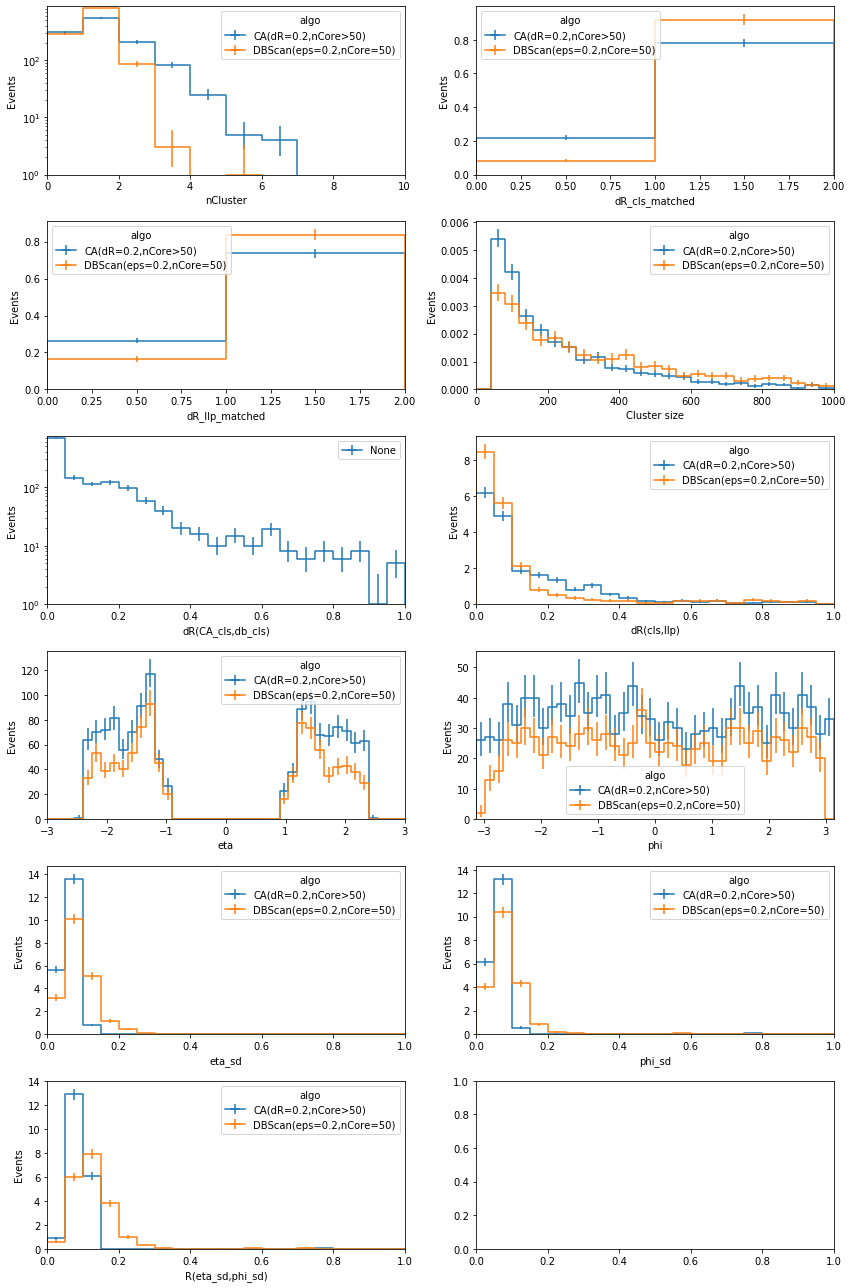

In [34]:
h=out['cluster']
c=out['cluster_spread']
d=out['delta_cls']
r=out['deltaR_llp']

ncols=2
nrows=6
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()


hist.plot1d(out['nCluster'],ax=axs[0]    ,density=False, overlay='algo')
axs[0].set_ylim(1, None)
axs[0].set_yscale('log')
hist.plot1d(h.project('algo','cls_matched'),ax=axs[1],density=True, overlay='algo')
hist.plot1d(h.project('algo','llp_matched'),ax=axs[2],density=True, overlay='algo')
hist.plot1d(h.project('algo','size'),ax=axs[3],density=True, overlay='algo')
# axs[3].set_ylim(1,None)
# axs[3].set_yscale('log')
hist.plot1d(d,ax=axs[4] ,density=False)
axs[4].set_ylim(1, None)
axs[4].set_xlim(0,1)
axs[4].set_yscale('log')
hist.plot1d(r,ax=axs[5] ,density=True,overlay='algo')
# axs[5].set_ylim(1, None)
axs[5].set_xlim(0,1)
# axs[5].set_yscale('log')

hist.plot1d(h.project('algo','eta'),ax=axs[6],density=False, overlay='algo')
hist.plot1d(h.project('algo','phi'),ax=axs[7],density=False, overlay='algo')

hist.plot1d(c.project('algo','eta_sd'),ax=axs[8],density=True, overlay='algo')
hist.plot1d(c.project('algo','phi_sd'),ax=axs[9],density=True, overlay='algo')
hist.plot1d(c.project('algo','width'),ax=axs[10],density=True, overlay='algo')
# axs[10].set_ylim(1,None)
# axs[10].set_yscale('log')




plt.tight_layout()
plt.show()

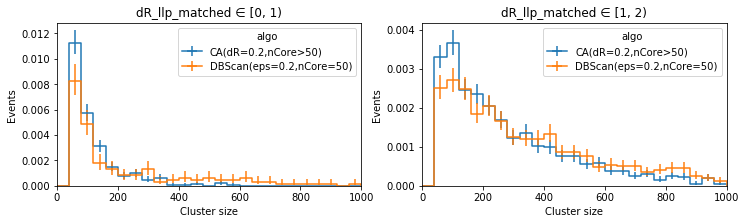

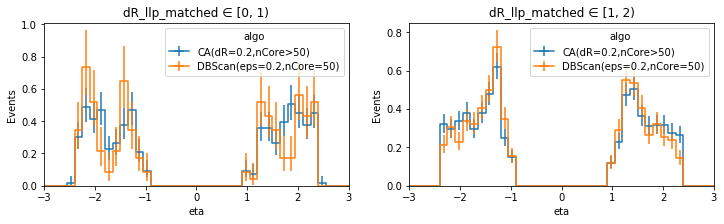

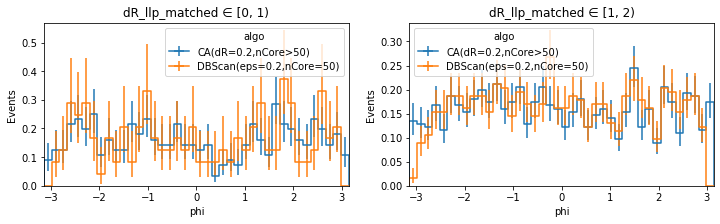

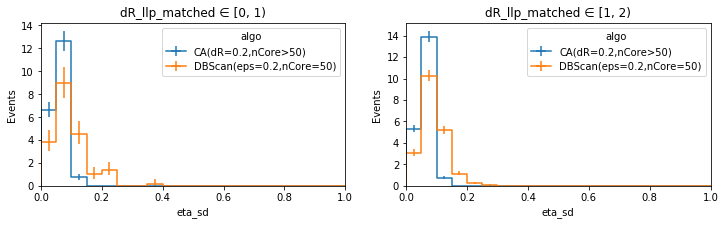

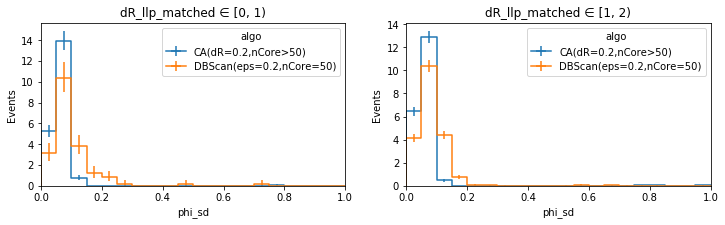

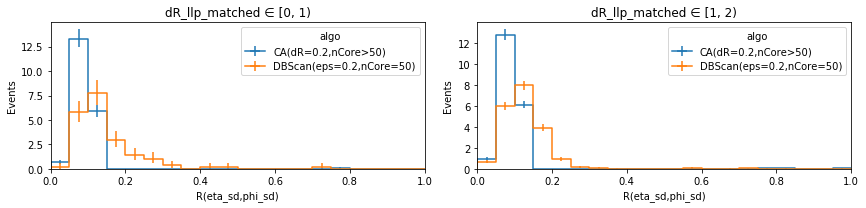

In [35]:
h=out['cluster']
r=out['cluster_spread']

ncols=2
nrows=1
figsize=(6,3)

axs=[]

# h = h.integrate('llp_matched',slice(1,None))

h= h.rebin("size", hist.Bin("size", "Cluster size", 25,0,1000))

for i,a in enumerate(['size','eta','phi']):
    fig, axs = plt.subplots(nrows,ncols,
                            figsize=[ncols*figsize[0],nrows*figsize[1]])    
    hist.plotgrid(
        h.project(a,'algo','llp_matched'),
        figure=fig,
        col='llp_matched',
        overlay='algo',
        density=True,
    )
for i,a in enumerate(['eta_sd','phi_sd','width']):
    fig, axs = plt.subplots(nrows,ncols,
                            figsize=[ncols*figsize[0],nrows*figsize[1]])    
    hist.plotgrid(
        r.project(a,'algo','llp_matched'),
        figure=fig,
        col='llp_matched',
        overlay='algo',
        density=True,
    )    
plt.tight_layout()
plt.show()

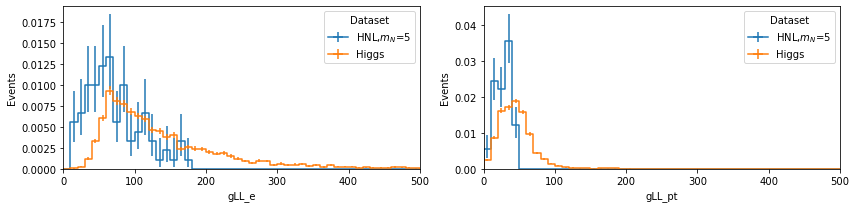

In [8]:

# hists = [
#     out["llp"],
# ]
h=out['llp']

ncols=2
nrows=1
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

# for i,h in enumerate(hists):
#     h.label='Density'
#     hist.plot1d(h,ax=axs[i], overlay='dataset',density=True,clear=False)

hist.plot1d(h.project('dataset','gLLP_e'),ax=axs[0], overlay='dataset',density=True,clear=False)
hist.plot1d(h.project('dataset','gLLP_pt'),ax=axs[1], overlay='dataset',density=True,clear=False)

plt.tight_layout()
plt.show()